<a href="https://colab.research.google.com/github/kerryback/WRDS/blob/main/Black_Jensen_Scholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Overview

We're going to form portfolios based on rolling-window beta estimates.  Then, we ask whether the returns of these portfolios are consistent with the CAPM.  We present both of the tests proposed by Black, Jensen, and Scholes.

In [1]:
!pip install --upgrade statsmodels

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Open the file created and saved in the WRDS notebook.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/crsp_compustat_example.csv', parse_dates=['date'])
df.date = df.date.dt.to_period('M')
df = df.sort_values(by=['permno','date'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Merge the market excess return and risk-free rate

Use the pandas data reader to read the Fama-French factors from Ken French's data library.  The data reader returns a dictionary.  The key 0 corresponds to the value-weighted monthly returns.  The returns are in percentage format (10%=10).  Divide by 100 to convert them to decimals (10%=0.10).  Then merge the market excess return and risk-free rate into the CRSP/Compustat data, broadcasting them across permnos.

In [4]:
import pandas_datareader as pdr
ff = pdr.DataReader('F-F_Research_Data_Factors','famafrench',start='1962-01-01')[0] / 100
df = df.merge(ff[['Mkt-RF','RF']],left_on='date',right_index=True,how='left')

# Betas from rolling-window regressions

In [5]:
# rolling 60-month regressions
# use try/except to avoid interruption with error message when a stock is in the dataset for fewer than 60 months

from statsmodels.regression.rolling import RollingOLS
def rollingBeta(d) :
    try :
        result = RollingOLS(d.ret-d.RF,sm.add_constant(d['Mkt-RF']),window=60,min_nobs=24).fit()
        result = pd.DataFrame(result.params['Mkt-RF'])
        result.index = d.date
        result.columns = ['beta']
        return result
    except :
        return pd.DataFrame(np.nan,index=d.date,columns=['beta'])
betas = df.groupby('permno').apply(rollingBeta)
df = df.merge(betas,left_on=['permno','date'],right_index=True,how='left')

# Sort and compute value weighted returns

Sort into deciles each month by the lagged beta estimate and compute portfolio returns (value weighted within deciles).

In [6]:
# lag market equity and beta one month
df.me = df.groupby('permno').me.shift()
df.beta = df.groupby('permno').beta.shift()
df = df.dropna(subset=['me','beta','ret'],how='any')

# we burn the first 60 months for the first set of betas, so drop from dataframe
df = df[df.date>=df.date.min()+60]

# sort into beta deciles each month
df['decile'] = df.groupby('date').beta.apply(lambda x: pd.qcut(x,10,labels=range(1,11)))

# compute value-weighted returns
rets = df.groupby(['date','decile']).apply(lambda d: (d.me*d.ret).sum() / d.me.sum())
rets = rets.unstack('decile')

# merge market excess return and risk-free rate
rets = rets.merge(ff[['Mkt-RF','RF']],left_index=True,right_index=True,how='inner')

In [7]:
# compute value-weighted returns
rets = df.groupby(['date','decile']).apply(lambda d: (d.me*d.ret).sum() / d.me.sum())
rets = rets.unstack('decile')

# merge market excess return and risk-free rate
rets = rets.merge(ff[['Mkt-RF','RF']],left_index=True,right_index=True,how='inner')

# BJS Test I

Test whether $\alpha=0$ in a time-series regression for each beta portfolio:
$$R-RF = \alpha + \beta (Mkt-RF) + \varepsilon$$
This is a separate test for each portfolio.  We'll pull the alphas, t-stats, and p-values into a dataframe.  We'll also add the betas.  

We can see that the low-beta (ex ante) portfolios do have lower betas (ex post).  The low beta portfolios also have positive alphas, contradicting the CAPM.

In [8]:
df[df.ret==df.ret.min()].shape

(166, 16)

In [9]:
table = pd.DataFrame(dtype=float,index=range(1,11),columns=['beta','rprem','alpha','tstat','pval'])
X = sm.add_constant(rets['Mkt-RF'])
for i in range(1,11) :
    y = rets[i]-rets.RF
    result = sm.OLS(y,X).fit()
    table.loc[i,'beta'] = result.params['Mkt-RF']
    table.loc[i,'rprem'] = y.mean()
    table.loc[i,'alpha'] = result.params['const']
    table.loc[i,'tstat'] = result.tvalues['const']
    table.loc[i,'pval'] = result.pvalues['const']
table.round(3)    

,beta,rprem,alpha,tstat,pval
1,0.526,0.005,0.002,1.586,0.113
2,0.647,0.006,0.002,2.469,0.014
3,0.756,0.007,0.002,2.928,0.004
4,0.852,0.007,0.002,2.471,0.014
5,0.963,0.007,0.001,0.944,0.346
6,1.038,0.007,0.001,0.775,0.439
7,1.160,0.007,-0.001,-0.849,0.396
8,1.251,0.007,-0.001,-0.986,0.324
9,1.448,0.006,-0.003,-2.214,0.027
10,1.687,0.007,-0.003,-2.008,0.045


# BJS Test II

This is a test of whether average excess returns depend on full-sample ex-post betas as predicted by the Security Market Line.  The Security Market Line is
$$E[R-RF] = \beta E[Mkt-RF]$$
so if we regress average excess returns on betas, we should get an intercept of 0 and a slope coefficient equal to the mean market excess return.  Empirically, the intercept is too large and the line is too flat.

In [10]:
X = sm.add_constant(table.beta)
y = table.rprem
sm.OLS(y,X).fit().summary()

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rprem   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     2.398
Date:                Tue, 08 Mar 2022   Prob (F-statistic):              0.160
Time:                        19:18:32   Log-Likelihood:                 60.886
No. Observations:                  10   AIC:                            -117.8
Df Residuals:                       8   BIC:                            -117.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.001      9.462      0.000       0.004       0.007
beta           0.0009      0.001      1.549      0.160      -0.000       0.002
==============================================================================
Omnibus:                        0.955   Durbin-Watson:                   1.249
Prob(Omnibus):                  0.620   Jarque-Bera (JB):                0.459
Skew:                          -0.492   Prob(JB):                        0.795
Kurtosis:                       2.633   Cond. No.                         6.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can visualize the fact that the empirical SML is too flat and has an intercept that is too large by comparing it to the theoretical SML as follows.  The slope of the theoretical SML is the market risk premium.

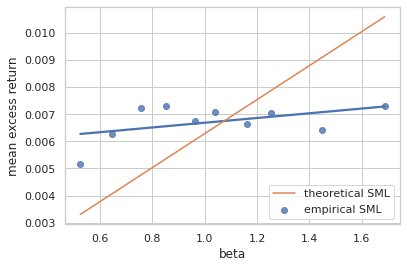

In [14]:

sns.regplot(data=table,x='beta',y='rprem',ci=None,label='empirical SML')
mkt_riskprem = rets['Mkt-RF'].mean()
plt.plot(table.beta,mkt_riskprem*table.beta,label='theoretical SML')
plt.xlabel('beta')
plt.ylabel('mean excess return')
plt.legend(loc='lower right')

# Save data frame with betas

In [15]:
df.to_csv('/content/drive/My Drive/crsp_compustat_example.csv',index=False)